In [2]:
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
import os

def read_csv_files(directory_path):
    # Initialize an empty list to hold the DataFrames
    data_frames = []
    
    # Iterate over all the files in the directory
    for filename in os.listdir(directory_path):
        # Check if the file is a CSV file
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            person_name = filename.split('_deepfake')[0]
            # Read the CSV file and grab the first `max_rows` rows
            df = pd.read_csv(file_path)
            df['person'] = person_name
            # Append the DataFrame to the list
            data_frames.append(df)
    
    # Concatenate all the DataFrames in the list into a single DataFrame
    combined_df = pd.concat(data_frames, ignore_index=True)
    
    return combined_df

current_dir = os.path.dirname(os.getcwd())
directory_path = os.path.join(current_dir, "cis_663_summer_24/Data/voice_recognition")
combined_df = read_csv_files(directory_path)

combined_df.size

315606

In [4]:
bona_fide_df = combined_df[combined_df['label'] == 'bona-fide']
spoof_df = combined_df[combined_df['label'] == 'spoof']

# Verify that no rows in 'bona_fide_df' have the label 'spoof'
assert bona_fide_df['label'].eq('spoof').sum() == 0, "There are 'spoof' labels in 'bona_fide_df'"

# Verify that no rows in 'spoof_df' have the label 'bona-fide'
assert spoof_df['label'].eq('bona-fide').sum() == 0, "There are 'bona-fide' labels in 'spoof_df'"


In [5]:
def balance_data_by_person(data):
    # Get the minimum number of rows available for any person
    min_rows = data['person'].value_counts().min()
    
    # Sample the minimum number of rows for each person
    balanced_data = data.groupby('person').apply(lambda x: x.sample(min_rows)).reset_index(drop=True)
    
    return balanced_data

identification_data = bona_fide_df.copy()  # CHOOSE CLASSIFICATION DATA, if you want to classify deepfakes, use combined_df.copy(), bona_fide_df otherwise
identification_data.reset_index(drop=True, inplace=True)
identification_data = balance_data_by_person(identification_data)  # COMMENT OUT if you want to classify deepfakes

# Split the data into features and labels
X = identification_data.drop(columns=['label', 'person'])
y = identification_data['person']  # CHOOSE CLASSIFICATION DATA, if you want to classify deepfakes, use 'label', otherwise 'person'

identification_data.head()

/var/folders/kp/ppx0111165b_t2bg2npfpzxr0000gn/T/ipykernel_77544/792680666.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('person').apply(lambda x: x.sample(min_rows)).reset_index(drop=True)


,chroma,centroid,bandwidth,zcr,energy,contrast,rolloff,pitch,mfcc_1,mfcc_2,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label,person
0,0.283925,193.707460,83.090545,0.021993,11.189106,25.077536,246.381579,216.708120,-697.963545,68.887709,...,29.087614,16.051473,3.897777,-6.585004,-14.897428,-20.840914,-24.483976,-26.096417,bona-fide,alan_watts
1,0.349851,193.095002,91.440993,0.021210,31.672905,24.742753,249.678938,210.592671,-620.200800,53.009262,...,24.997218,15.352996,6.048585,-2.320434,-9.311777,-14.663834,-18.298117,-20.299464,bona-fide,alan_watts
2,0.380444,214.738425,157.032420,0.022008,0.000095,20.182823,292.131696,248.026329,-1075.049585,73.352773,...,36.909955,25.574273,14.375810,3.705566,-5.769704,-13.619641,-19.642650,-23.679457,bona-fide,alan_watts
3,0.362635,184.834741,63.799847,0.022155,41.349994,26.446942,236.638435,213.380223,-611.040638,41.286486,...,19.919058,12.419678,5.083428,-1.632971,-7.373688,-11.906884,-15.131331,-17.067567,bona-fide,alan_watts
4,0.385199,198.812173,151.212002,0.020281,0.001251,21.011240,239.676339,275.153439,-1063.980727,77.900670,...,39.660809,27.153992,14.850413,3.336355,-6.825305,-15.061963,-21.132740,-25.046206,bona-fide,alan_watts


In [6]:
authentication_data_missing_values = identification_data.isnull().sum()

print("Columns with missing values:")
authentication_data_missing_values

Columns with missing values:


chroma       0
centroid     0
bandwidth    0
zcr          0
energy       0
contrast     0
rolloff      0
pitch        0
mfcc_1       0
mfcc_2       0
mfcc_3       0
mfcc_4       0
mfcc_5       0
mfcc_6       0
mfcc_7       0
mfcc_8       0
mfcc_9       0
mfcc_10      0
mfcc_11      0
mfcc_12      0
mfcc_13      0
label        0
person       0
dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder

# Prepare the data

# Encode categorical labels to numeric
label_encoder = LabelEncoder()
# identification_data['label'] = label_encoder.fit_transform(identification_data['label'])  # Comment out for 'person' classification
identification_data['person'] = label_encoder.fit_transform(identification_data['person'])  # comment out for deepfake classification

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Below is for a combined classification experiment

In [30]:
# # Create a combined target column
# identification_data['combined_label'] = identification_data['label'] + '_' + identification_data['person']

# # Encode the combined labels to numeric
# label_encoder = LabelEncoder()
# identification_data['combined_label'] = label_encoder.fit_transform(identification_data['combined_label'])

# # Split the data into features and combined labels
# X = identification_data.drop(columns=['label', 'person', 'combined_label'])
# y = identification_data['combined_label']

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U1')) -> None

SVM Model

In [8]:
from sklearn.svm import SVC


# Create and train the SVM model
svm_classifier = SVC(kernel='rbf', probability=True)
svm_classifier.fit(X_train, y_train)
# Make predictions
y_pred = svm_classifier.predict(X_test)


Accuracy Scores and Classification Matrices


Accuracy Score:
0.5
                          precision    recall  f1-score   support

              alan_watts       0.58      0.39      0.47        18
           alec_guinness       0.47      0.62      0.53        13
alexandria_ocasio-cortez       0.26      0.26      0.26        19
                ayn_rand       0.50      0.42      0.46        19
            barack_obama       0.44      0.31      0.36        26
          bernie_sanders       0.43      0.35      0.39        17
            bill_clinton       0.68      0.68      0.68        19
    christopher_hitchens       0.38      0.53      0.44        15
            donald_trump       0.50      0.40      0.44        15
                     fdr       0.60      0.33      0.43        18
                     jfk       0.52      0.88      0.65        16
         louis_farrakhan       0.45      0.33      0.38        15
         mark_zuckerberg       0.50      0.54      0.52        13
      martin_luther_king       0.65      0.79      0.7

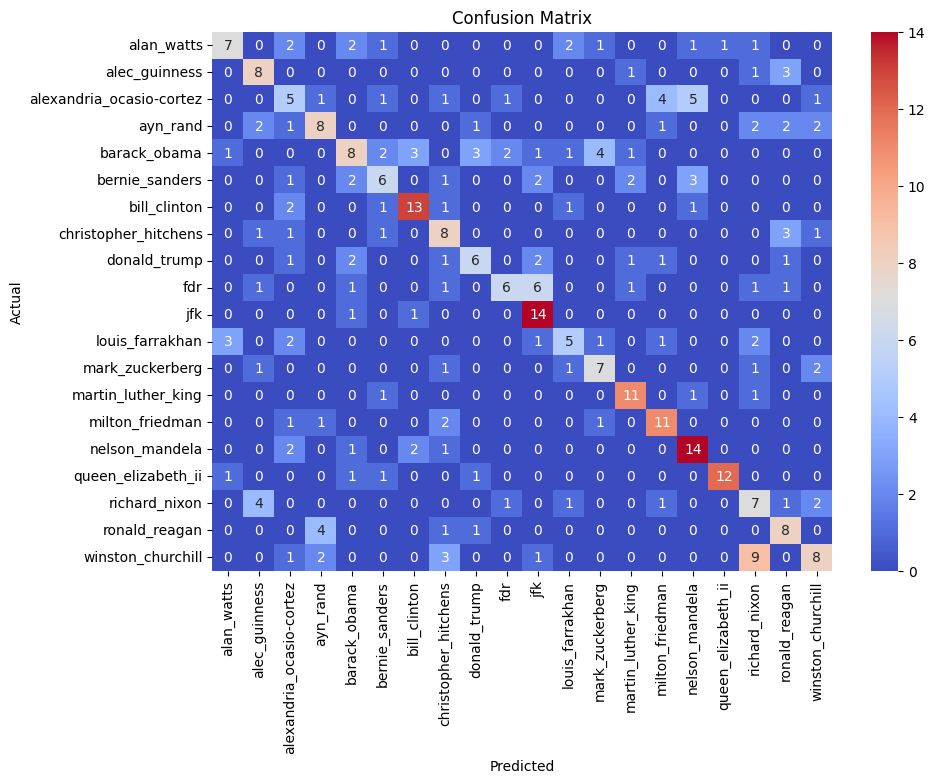

In [39]:
import seaborn as sns
from sklearn import metrics

print("\nAccuracy Score:")
print(metrics.accuracy_score(y_test, y_pred))
classification = metrics.classification_report(y_test, y_pred)
print(classification)

# Generate confusion matrix
confusion = metrics.confusion_matrix(y_test, y_pred)

# Get class names for the labels
class_names = label_encoder.inverse_transform(sorted(label_encoder.transform(label_encoder.classes_)))  # Comment out for deepfake classification
# class_names = label_encoder.classes_  # Comment out for person identification

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, cmap="coolwarm", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Deep Learning Model

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Parameters
learning_rate = 0.001
epochs = 50
batch_size = 64
patience = 5  # For early stopping

# Model definition with Batch Normalization
class VoiceClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(VoiceClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.output = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

# Instantiate the model, define the loss function, optimizer, and scheduler
input_size = X.shape[1]
num_classes = len(label_encoder.classes_)
model = VoiceClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early stopping
early_stopping_counter = 0
best_loss = float('inf')

# Data loaders
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')
    
    # Validate and adjust learning rate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    scheduler.step(val_loss)
    
    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Convert predictions and labels to numpy arrays
y_pred = np.array(all_preds)
y_test = np.array(all_labels)

# Classification report and confusion matrix
print("\nClassification Report (Deep Learning):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, cmap="coolwarm", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Deep Learning)')
plt.show()


/Users/chandlerjohns/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


KeyError: 250

Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=42, max_features='sqrt', bootstrap=True, min_samples_leaf=1, min_samples_split=2)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estim

/var/folders/kp/ppx0111165b_t2bg2npfpzxr0000gn/T/ipykernel_77544/2858853561.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results['param_max_depth'] = results['param_max_depth'].fillna(0).astype(int)


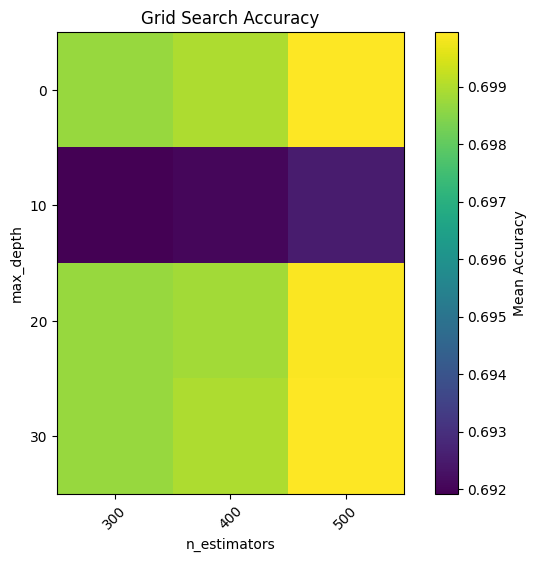

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming grid_search is your fitted GridSearchCV object
results = pd.DataFrame(grid_search.cv_results_)
results['param_max_depth'] = results['param_max_depth'].fillna(0).astype(int)

# Extract mean test scores
mean_test_scores = results['mean_test_score']

# You can choose different hyperparameters to plot, for example, `n_estimators` and `max_depth`
param_n_estimators = results['param_n_estimators'].astype(int)
param_max_depth = results['param_max_depth'].astype(int)

# Pivot the data to create a matrix of scores
scores_matrix = pd.pivot_table(results, values='mean_test_score', 
                               index='param_max_depth', columns='param_n_estimators')

# Plotting the heatmap of grid search scores
plt.figure(figsize=(8, 6))
plt.title('Grid Search Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.imshow(scores_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='Mean Accuracy')

# Adding labels
plt.xticks(np.arange(len(scores_matrix.columns)), scores_matrix.columns, rotation=45)
plt.yticks(np.arange(len(scores_matrix.index)), scores_matrix.index)
plt.show()

In [38]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=8)  # You can adjust the number of neighbors (k)
knn_classifier.fit(X_train, y_train)

# Make predictions
y_pred = knn_classifier.predict(X_test)

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 8, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create a k-NN classifier
knn = KNeighborsClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Accuracy: ", grid_search.best_score_)

# Predict using the best estimator
best_knn = grid_search.best_estimator_


Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Cross-Validation Accuracy:  0.6482450592885376


In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Get the predicted probabilities
y_score = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multiclass')
plt.legend(loc="lower right")
plt.show()

KeyError: 'key of type tuple not found and not a MultiIndex'